In [3]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
from neuraltda import TPLCP
reload(TPLCP)

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<module 'neuraltda.TPLCP' from '/home/brad/code/NeuralTDA/neuraltda/TPLCP.py'>

In [4]:
block_path = '/home/brad/krista/B1075/P01S03/'
block_path = '/home/brad/krista/B1083/P03S03/'
bdf = glob.glob('/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-fulltrial/20170626T223014Z-10.0-5.0.binned')[0]

birds = ['B1083', 'B1075', 'B1235']
#birds = ['B1075']

bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/', 'B1235': '/home/brad/krista/B1235/P02S01/'}

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes, 'B1235': B1235_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims, 'B1235': B1235_stims}

In [6]:
winsize = 10.0
dtovr = winsize*0.5
comment = 'ForLogisticPred'
segment_info = [0,0]

bdfs = []
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs.append([bird, bdf])

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T191746Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194237Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194243Z-10.0-5.0.binned


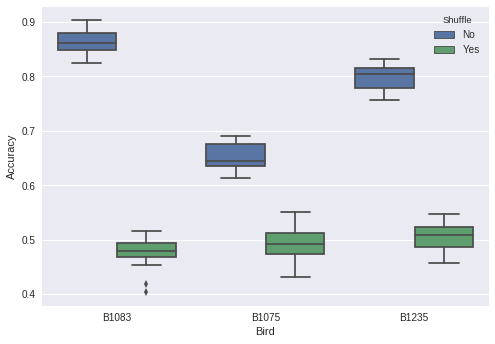

In [9]:
# Behavioral class decoder accuracy vs shuffled. 

reload(tp2)
analysis_id = 'test'
thresh = 4.0
nperms = 20
ncellsperm = 30
dim = 2
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 30

name = 'ShuffleClassLabels'
acframe = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    stimc = stim_classes[bird]
    stims = bird_stims[bird]
    (bc2, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr)
    (bc1, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr)
    (bc0, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr)
    (bc3, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr)
    

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    

    accuracies = TPLCP.predict_stimuli_classes([bc1, bc2, bc0, bc3], Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes([bc1, bc2, bc0, bc3], Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe = acframe.append(acframeapp)
    acframe = acframe.append(acframeapps)

    
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe)
plt.savefig('/home/brad/DailyLog/20170724/{}-{}-{}-{}-{}-{}-{}-{}-{}.png'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

In [ ]:
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1083_unfclasses = {'I_40k': 'L', 'J_40k': 'R', 'K_40k': 'L', 'L_40k':'R'}

B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
unfstims = ['I_40k', 'J_40k', 'K_40k', 'L_40k']

accuracies = TPLCP.predict_stimuli_classes([bc1, bc2, bc0], Ntimes, stims, B1083_classes, p_test, N_tests)
print(np.mean(accuracies))

unfacc = TPLCP.predict_stimuli_classes([bc1, bc2, bc0], Ntimes, unfstims, B1083_unfclasses, p_test, N_tests)
print(np.mean(unfacc))

B1083
Completed Betti Computation...
B1075
Completed Betti Computation...
B1235
Completed Betti Computation...


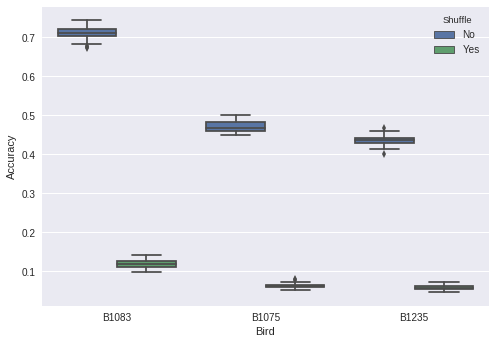

In [8]:
# Decode stimulus name

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes, 'B1235': B1235_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims, 'B1235': B1235_stims}

reload(tp2)
analysis_id = 'test'
thresh = 4.0
nperms = 20
ncellsperm = 30
dim = 2
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 30

name = 'PredictStimulusID'
acframe = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    #stimc = stim_classes[bird]
    #stims = bird_stims[bird]
    (bc2, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr)
    (bc1, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr)
    (bc0, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr)
    (bc3, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr)
    print('Completed Betti Computation...')

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    
    stims = bc0.keys()
    stimc = {x: x for x in stims}
    accuracies = TPLCP.predict_stimuli_classes([bc1, bc2, bc0, bc3], Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes([bc1, bc2, bc0, bc3], Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe = acframe.append(acframeapp)
    acframe = acframe.append(acframeapps)

    
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe)
plt.savefig('/home/brad/DailyLog/20170725/{}-{}-{}-{}-{}-{}-{}-{}-{}.png'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

In [ ]:
    plt.figure()
    sns.boxplot( y = [accuracies, accuracies_shuff])

In [1]:
test = [1,2,3,4]
t = {x: x for x in test}

In [2]:
t

{1: 1, 2: 2, 3: 3, 4: 4}